# Lista 02

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

from itertools import combinations

In [2]:
random.seed(42)

3. Utilize o dataset lalonde visto no exemplo da aula 02 e implemente o FRT utilizando a estatística _t_ studentizada e a estatística de soma de postos de Wilcoxon. Compare os _p-valores_ obtidos com suas versões asintóticas.

In [3]:
def get_lalonde(version='R'):
    if version.lower() == 'online':
        column_names = ['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']
        df_treated = pd.read_csv(r'..\Lista01\nswre74_treated.txt', names=column_names, sep=r"\s+|;|:|,", engine='python')
        df_control = pd.read_csv(r'..\Lista01\nswre74_control.txt', names=column_names, sep=r"\s+|;|:|,", engine='python')
        lalonde = pd.concat ([df_treated, df_control])
        lalonde = lalonde.reset_index(drop=True)
    elif version.lower() == 'peng':
        lalonde = pd.read_csv(r'..\Lista01\cps1re74.csv', sep=r"\s+|;|:|,", engine='python')
    elif version.lower() == 'r':
        lalonde = pd.read_csv(r'.\R\Lalonde.csv', sep=r"\s+|;|:|,", engine='python')
    else:
        raise ValueError(f'{version} is not a valid option.')

    lalonde['treat'] = lalonde['treat'].astype(int)
    lalonde['u74'] = (lalonde['re74'] == 0).astype(int)
    lalonde['u75'] = (lalonde['re75'] == 0).astype(int)

    new_column_names = ["treat", "age", "educ", "black", "hispan", "married", "nodegree", "re74", "re75", "u74", "u75", "re78"]
    return lalonde.reindex(columns=new_column_names)

In [4]:
lalonde = get_lalonde('r')
n1 = lalonde['treat'].sum()
n0 = (1-lalonde['treat']).sum()
n = n1 + n0
print(f'n1 = {n1}, n0 = {n0}, n = {n}')

n1 = 185, n0 = 260, n = 445


In [5]:
def tau_hat(y1, y0):
    return y1.mean() - y0.mean()

def tau_hat_normal(y1, y0):
    s2 = np.var(np.concatenate((y1,y0)), ddof=1)
    alfa = np.sqrt(n/(n1*n0) * s2)
    return tau_hat(y1,y0) / alfa

def studentized(y1, y0):
    s2_1 = np.var(y1, ddof=1)
    s2_0 = np.var(y0, ddof=1)
    dif_means = tau_hat(y1,y0)
    return dif_means / np.sqrt(s2_1 / n1 + s2_0/n0)

def wilcoxon(y1, y0):
    y = np.concatenate((y1,y0))
    z = pd.Series([1] * n1 + [0] * n0)
    r = []
    for i in range(len(y)):
        r.append((y <= y[i]).sum())
    r_avg_rank = []
    for i in range(len(r)):
        rep = sum(1 for x in r if x==r[i]) - 1
        r_avg_rank.append(r[i] - rep/2)
    r = pd.Series(r_avg_rank)
    return r.dot(z) - n1*(n+1)/2

def wilcoxon_normal(y1, y0):
    w = wilcoxon(y1,y0)
    alfa = n1*n0*(n+1)/12
    return w / np.sqrt(alfa)

In [6]:
y1 = lalonde['re78'][lalonde['treat']==1]
y0 = lalonde['re78'][lalonde['treat']==0]

print(f'y1 mean hat = {y1.mean():.2f}')
print(f'y0 mean hat = {y0.mean():.2f}')

tau_hat_ = tau_hat(y1,y0)
tau_hat_normal_ = tau_hat_normal(y1,y0)
t_student_ = studentized(y1,y0)
wilcoxon_ = wilcoxon(y1,y0)
wilcoxon_normal_ = wilcoxon_normal(y1,y0)

print(f'tau_hat = {tau_hat_:.2f}')
print(f'tau_hat_normal = {tau_hat_normal_:.4f}')
print(f't_student = {t_student_:.4f}')
print(f'W = {wilcoxon_}')
print(f'W_normal = {wilcoxon_normal_:.4f}')

y1 mean hat = 6349.15
y0 mean hat = 4554.80
tau_hat = 1794.34
tau_hat_normal = 2.8131
t_student = 2.6741
W = 3352.5
W_normal = 2.5074


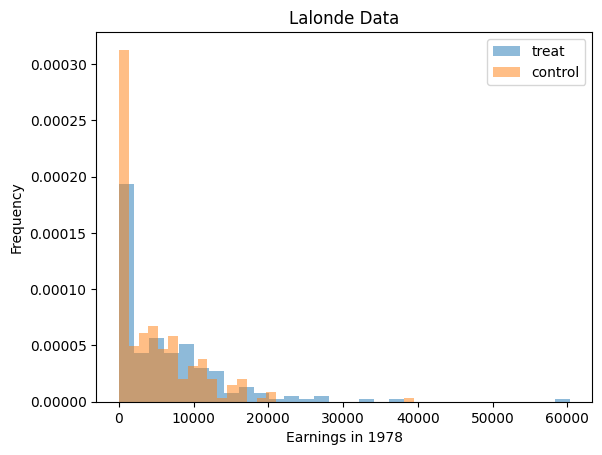

In [7]:
plt.hist(y1, bins=30, alpha=0.5, label='treat', density=True)
plt.hist(y0, bins=30, alpha=0.5, label='control', density=True)
plt.xlabel('Earnings in 1978')
plt.ylabel('Frequency')
plt.title('Lalonde Data')
plt.legend()
plt.show()

In [8]:
mc = 10000
progress_bar = tqdm(total=mc, desc="Progress")

tau_hat_list = []
t_student_list = []
wilcoxon_list = []
z_random = lalonde['treat'].copy()
for i in range(mc):
    random.shuffle(z_random)

    y1_ = lalonde['re78'][z_random==1]
    y0_ = lalonde['re78'][z_random==0]

    tau_hat_list.append(tau_hat(y1_,y0_))
    t_student_list.append(studentized(y1_,y0_))
    wilcoxon_list.append(wilcoxon(y1_,y0_))
    progress_bar.update(1)

progress_bar.close()

tau_hat_p_value = sum([1 for t in tau_hat_list if tau_hat_ < t]) / mc
t_student_p_value = sum([1 for t in t_student_list if t_student_ < t]) / mc
wilcoxon_p_value = sum([1 for w in wilcoxon_list if wilcoxon_ < w]) / mc

Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

Progress: 100%|██████████| 10000/10000 [11:35<00:00, 14.37it/s]


In [9]:
print('MC p-value')
print(f'  tau_hat: {tau_hat_p_value:.4f}')
print(f'  t-student: {t_student_p_value:.4f}')
print(f'  Wilcoxon: {wilcoxon_p_value:.4f}')

MC p-value
  tau_hat: 0.0020
  t-student: 0.0020
  Wilcoxon: 0.0036


In [10]:
print('Asymptotic p-value')
print(f'  tau_hat: {1-norm.cdf(tau_hat_normal_):.4f}')
print(f'  t-student: {1-norm.cdf(t_student_):.4f}')
print(f'  Wilcoxon: {1-norm.cdf(wilcoxon_normal_):.4f}')

Asymptotic p-value
  tau_hat: 0.0025
  t-student: 0.0037
  Wilcoxon: 0.0061


4. Faça um estudo de simulacão e compare $p_{FRT}$, $\hat{𝑝}_{𝐹𝑅𝑇}$ e $\tilde{𝑝}_{𝐹𝑅𝑇} = (1+𝑅)^{−1} \sum{}^R_{r=1} I(T(z^r,Y) \geq{} T(Z,Y))$ (utilize diversos valores de 𝑅).

In [40]:
n = 22
n1 = int(0.6*n)
n0 = n - n1
y0_pot = np.random.exponential(scale=1, size=n)
tau = np.random.normal(loc=1, scale=0.45, size=n)
y1_pot = y0_pot + tau

z = np.array(list([1]*n1 + [0]*n0))
y1 = y1_pot[z==1]
y0 = y0_pot[z==0]
y = np.concatenate((y1,y0))

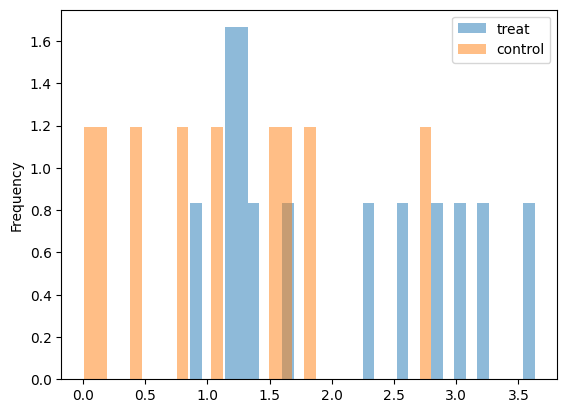

In [41]:
plt.hist(y1, bins=30, alpha=0.5, label='treat', density=True)
plt.hist(y0, bins=30, alpha=0.5, label='control', density=True)
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [42]:
all_combinations = list(combinations(list(range(n)), n1))
random.shuffle(all_combinations)

In [43]:
print(f'n1 = {n1}')
print(f'n0 = {n0}')
print(f'Number of combinations = {len(all_combinations):,}')

n1 = 13
n0 = 9
Number of combinations = 497,420


In [44]:
stat_test = tau_hat # studentized, wilcoxon

t_ = stat_test(y1,y0)
print(f'Statistic = {t_}')

t_i = []
for c in all_combinations:
    y1_random = y[list(c)]
    y0_random = y[~np.isin(y, y1_random)]
    t_i.append(stat_test(y1_random, y0_random))
p_FRT = sum([1 for t in t_i if t_ < t]) / len(all_combinations)

print(f'Exact pFRT = {p_FRT}')

Statistic = 0.8825330665386277
Exact pFRT = 0.019677536086204817


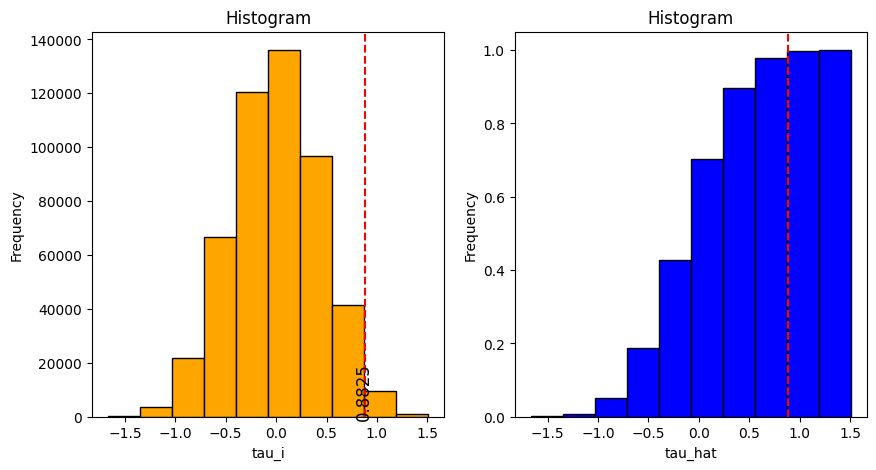

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(t_i, color='orange', edgecolor='black')
axs[0].set_xlabel('tau_i')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram')
axs[0].axvline(x=t_, color='r', linestyle='--')
axs[0].annotate(f'{t_:0.4f}',
                xy=(t_, 50),
                xytext=(t_*.99, 50),
                fontsize=12, ha='center', rotation=90)

axs[1].hist(t_i, color='blue', edgecolor='black', cumulative=True, density=True)
axs[1].set_xlabel('tau_hat')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram')
axs[1].axvline(x=t_, color='r', linestyle='--')

plt.show()

In [46]:
r_tests = np.logspace(
    base=10,
    start=1,
    stop=min(np.log10(len(all_combinations)), 6),
    num=20).astype(int)

p_FRT_hat = []
p_FRT_tilde = []
for r in r_tests:
    random_indexes = np.random.choice(np.arange(len(all_combinations)),
                                      size=r, replace=True)
    t_i_ = [t_i[i] for i in random_indexes[:r]]
    n_pass = sum([1 for t in t_i_ if t_ < t])
    p_FRT_hat.append(n_pass / r)

    random_indexes = np.random.choice(np.arange(len(all_combinations)),
                                      size=r, replace=True)
    t_i_ = [t_i[i] for i in random_indexes[:r]]
    n_pass = sum([1 for t in t_i_ if t_ < t])
    p_FRT_tilde.append(n_pass / (r+1))

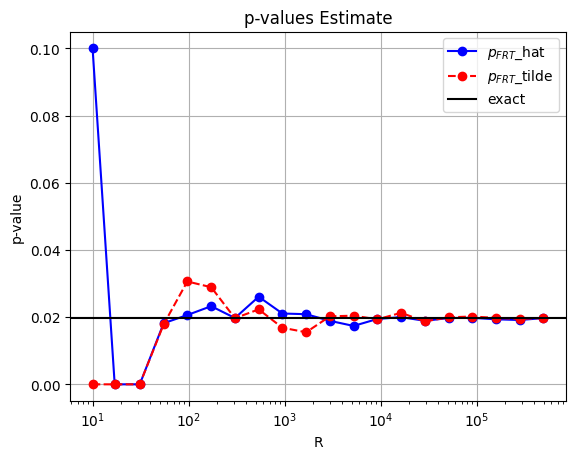

In [47]:
plt.plot(r_tests, p_FRT_hat,
         color='blue', linestyle='-', marker='o',
         label='$p_{FRT}$_hat')
plt.plot(r_tests, p_FRT_tilde,
         color='red', linestyle='--', marker='o',
         label='$p_{FRT}$_tilde')
plt.axhline(y=p_FRT,
            color='black', linestyle='-', label='exact')

plt.xscale('log')
plt.xlabel('R')
plt.ylabel('p-value')
plt.title('p-values Estimate')
plt.legend()

plt.grid(True)
plt.show()

6. Repita a ilustração feita na aula 03 mas utilizando, em lugar de $\hat{V}$ utilize $\tilde{V} = \frac{1}{n}[\sqrt{\frac{n_0}{n_1}}]$.

In [19]:
def make_tests(y1_pot, y2_pot):
    z = np.array(list([1]*n1 + [0]*n0))
    random.shuffle(z)

    y1 = y1_pot[z==1]
    y0 = y0_pot[z==0]

    y1_bar = y1_pot.mean()
    y0_bar = y0_pot.mean()
    tau = y1_bar - y0_bar

    s2_1 = np.var(y1_pot, ddof=1)
    s2_0 = np.var(y0_pot, ddof=1)
    # s_10 = np.cov(y1_pot, y0_pot, ddof=1)[1,0]

    tau_i = [(y1-y0) for y1,y0 in zip(y1_pot,y0_pot)]
    s2_tau = np.var(tau_i, ddof=1)

    var_tau_hat = s2_1/n1 + s2_0/n0 - s2_tau/n

    print('Exact')
    print(f' tau = {tau:.4f}')
    print(f' V(tau_i) = {s2_tau:.4f}')
    print(f' V(tau_hat) = {var_tau_hat:.4f}')
    # print(f' S(1,0) = {s_10}')

    y1_bar_hat = y1.mean()
    y0_bar_hat = y0.mean()
    tau_hat = y1_bar_hat - y0_bar_hat

    s2_1_hat = np.var(y1, ddof=1)
    s2_0_hat = np.var(y0, ddof=1)

    v_hat = s2_1_hat/n1 + s2_0_hat/n0
    v_tilde = (np.sqrt(n0/n1*s2_1_hat) + np.sqrt(n1/n0*s2_0_hat))**2 / n

    print('One Sample')
    print(f' tau = {tau_hat:.4f}')
    print(f' V_hat(tau) = {v_hat:.4f}')
    print(f' V_tilde(tau) = {v_tilde:.4f}')

    tau_hat_list = []
    v_hat_list = []
    v_tilde_list = []
    has_tau_v_hat_list = []
    has_tau_v_tilde_list = []

    mc = 10000
    z_ = z.copy()

    def _has_tau(tau_hat, var_hat):
        has_tau_ = (tau > tau_hat - 1.96*np.sqrt(v_hat))
        return has_tau_ and (tau < tau_hat + 1.96*np.sqrt(v_hat))

    for i in range(mc):
        random.shuffle(z_)
        y1_ = y1_pot[z_==1]
        y0_ = y0_pot[z_==0]

        y1_bar_hat_ = y1_.mean()
        y0_bar_hat_ = y0_.mean()
        tau_hat_list.append(y1_bar_hat_ - y0_bar_hat_)

        s2_1_hat_ = np.var(y1_, ddof=1)
        s2_0_hat_ = np.var(y0_, ddof=1)

        v_hat_list.append(s2_1_hat_/n1 + s2_0_hat_/n0)
        v_tilde_list.append((np.sqrt(n0/n1*s2_1_hat_) + np.sqrt(n1/n0*s2_0_hat_))**2 / n)

        has_tau_v_hat_list.append(_has_tau(tau_hat_list[-1], v_hat_list[-1]))
        has_tau_v_tilde_list.append(_has_tau(tau_hat_list[-1], v_tilde_list[-1]))

    print('CRE')
    print(f' tau = {np.mean(tau_hat_list):.4f}')
    print(f' V_hat(tau) = {np.mean(v_hat_list):.4f}')
    print(f' V_tilde(tau) = {np.mean(v_tilde_list):.4f}')

    coverage = [np.mean(has_tau_v_hat_list), np.mean(has_tau_v_tilde_list)]
    print(f' Has tau (V_hat) = {coverage[0]:.4f}')
    print(f' Has tau (V_tilde) = {coverage[1]:.4f}')

    fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    axs[0,0].hist(tau_hat_list, color='orange', edgecolor='black')
    axs[0,0].set_xlabel('')
    axs[0,0].set_ylabel('Frequency')
    axs[0,0].set_title('tau_hat Histogram')
    axs[0,0].axvline(x=tau, color='r', linestyle='--')
    axs[0,0].annotate(f'{tau:0.4f}',
                    xy=(tau, 50),
                    xytext=(tau*.99, 50),
                    fontsize=12, ha='center', rotation=90)

    axs[0,1].hist(v_hat_list, color='blue', edgecolor='black')
    axs[0,1].set_xlabel('')
    axs[0,1].set_ylabel('Frequency')
    axs[0,1].set_title('v_hat Histogram')
    axs[0,1].axvline(x=var_tau_hat, color='r', linestyle='--')

    axs[1,0].bar(['with v_hat','with v_tilde'], coverage, color=['blue', 'green'])
    axs[0,0].set_title('Coverage')

    axs[1,1].hist(v_tilde_list, color='green', edgecolor='black')
    axs[1,1].set_xlabel('')
    axs[1,1].set_ylabel('Frequency')
    axs[1,1].set_title('v_tilde Histogram')
    axs[1,1].axvline(x=var_tau_hat, color='r', linestyle='--')

    plt.show()

$\tau{}_i =cte$

In [20]:
n1 = 60
n0 = 40
n = n1 + n0
y0_pot = np.random.exponential(scale=1, size=n)
y0_pot.sort()
tau = 1
y1_pot = y0_pot + tau

Exact
 tau = 1.0000
 V(tau_i) = 0.0000
 V(tau_hat) = 0.0383
One Sample
 tau = 0.8741
 V_hat(tau) = 0.0367
 V_tilde(tau) = 0.0366
CRE
 tau = 1.0016
 V_hat(tau) = 0.0382
 V_tilde(tau) = 0.0378
 Has tau (V_hat) = 0.9443
 Has tau (V_tilde) = 0.9443


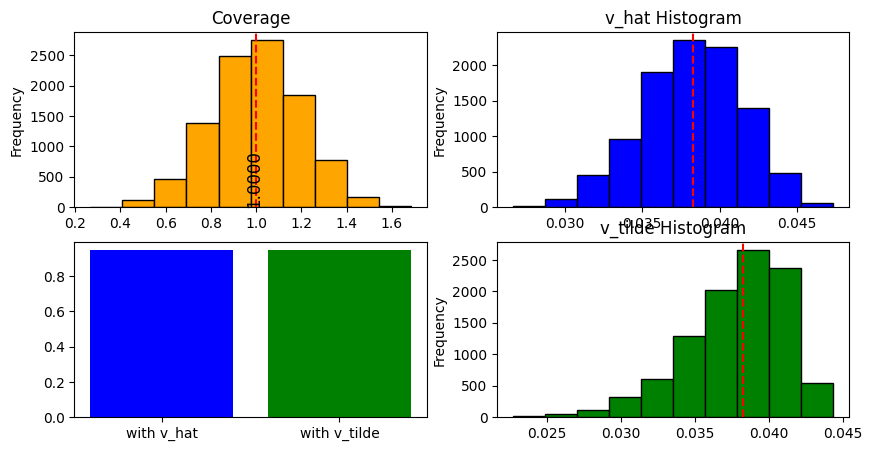

In [21]:
make_tests(y1_pot, y0_pot)

Maximize $Var(\tau{}_i)$

In [22]:
y0_pot = y0_pot[::-1]

Exact
 tau = 1.0000
 V(tau_i) = 3.1866
 V(tau_hat) = 0.0064
One Sample
 tau = 1.0053
 V_hat(tau) = 0.0282
 V_tilde(tau) = 0.0282
CRE
 tau = 1.0008
 V_hat(tau) = 0.0382
 V_tilde(tau) = 0.0380
 Has tau (V_hat) = 1.0000
 Has tau (V_tilde) = 1.0000


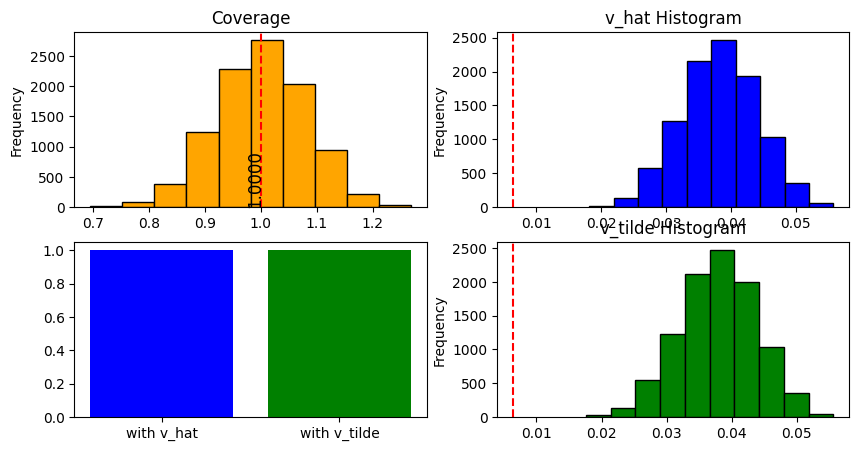

In [23]:
make_tests(y1_pot, y0_pot)

Some $Var(\tau{}_i)$

In [24]:
random.shuffle(y0_pot)

Exact
 tau = 1.0000
 V(tau_i) = 1.9560
 V(tau_hat) = 0.0187
One Sample
 tau = 1.1728
 V_hat(tau) = 0.0351
 V_tilde(tau) = 0.0350


CRE
 tau = 1.0011
 V_hat(tau) = 0.0382
 V_tilde(tau) = 0.0380
 Has tau (V_hat) = 0.9932
 Has tau (V_tilde) = 0.9932


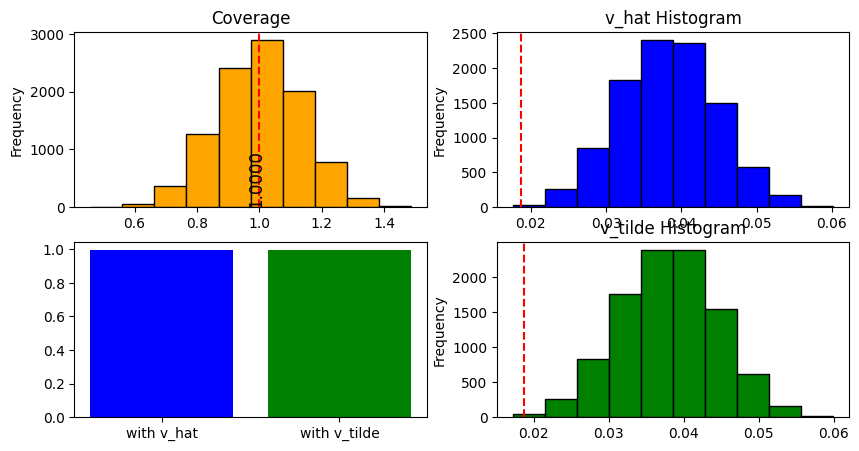

In [25]:
make_tests(y1_pot, y0_pot)